## **Quantum Approximate Optimization Algorithm on Real Quantum Hardware**

In this work, we will implement the **Quantum Approximate Optimization Algorithm (QAOA)** on actual quantum hardware. 

We will solve a **Max-Cut** problem for a small graph, and then we will execute it to a $100+$ node graph.

Visit [IBM Quantum Platform](https://quantum.cloud.ibm.com), to make an account, sign in with your email, select any region :


![alt-image](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/login_page.png)

---

Once you successfully login, you'll see the home page

![home-page](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/home_page.png)

---

And, can also view the list of quantum hardware and their properties:



![quantum-hardware](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/quantum_hardware.png)

So, with a free account, you get 10 minutes of Quantum Processing Unit (QPU) time, and access to two quantum hardware:


### 🔹 `ibm-torino`: A 133-Qubit Device 

`ibm-torino` is a 133-qubit quantum processor.

Here are its key specs:

| Property               | Value                                  |
|------------------------|----------------------------------------|
| **Qubits**             | 133                                    |
| **2Q Gate Error (best)** | $1.33 \times 10^{-3}$ (0.133%)        |
| **2Q Gate Error (layered)** | $6.35 \times 10^{-3}$ (0.635%)     |
| **CLOPS**              | 210K (210,000 operations/sec)          |
| **Status**             | Online                                 |
| **Pending Jobs**       | 5,588                                  |
| **Processor Type**     | Heron r1                               |
| **Region**             | us-east                                |

#### 💡 What Do These Numbers Mean?

- **Qubits (133)**: This is the number of quantum bits the device has. More qubits allow for more complex quantum circuits.
  
- **Two-Qubit (2Q) Gate Errors**: 
  - Quantum gates (like CNOT) that act on two qubits are more error-prone than single-qubit gates.
  - The **"best"** error rate ($1.33 \times 10^{-3}$) is the lowest measured error across the chip.
  - The **"layered"** error ($6.35 \times 10^{-3}$) reflects the average error when running layered circuits across the full device. This is more realistic for actual use.

- **CLOPS (210K)**: Stands for *Circuit Layer Operations Per Second*. It measures how fast the device can execute repeated quantum circuits. Higher CLOPS means faster experimentation.

- **Pending Jobs (5,588)**: This high number shows that `ibm-torino` is very popular! Jobs are queued, so your circuit may wait before running.

- **Heron r1 Architecture**: This is part of IBM’s newer Heron processor family, which features improved gate fidelities and connectivity compared to older chips.

---

### 🔹 `ibm_brisbane`: A 127-Qubit Quantum Computer

`ibm_brisbane` is a 127-qubit quantum processor. It's part of IBM's widely used Eagle-generation architecture.

| Property               | Value                                  |
|------------------------|----------------------------------------|
| **Qubits**             | 127                                    |
| **2Q Gate Error (best)** | $1.98 \times 10^{-3}$ (0.198%)        |
| **2Q Gate Error (layered)** | $7.29 \times 10^{-3}$ (0.729%)     |
| **CLOPS**              | 289K (289,000 operations/sec)          |
| **Status**             | Online                                 |
| **Pending Jobs**       | 4,239                                  |
| **Processor Type**     | Eagle r3                               |
| **Region**             | us-east                                |

#### 💡 Key Insights

- **Slightly Fewer Qubits, Slightly Higher Errors**: Compared to `ibm-torino`, `ibm_brisbane` has fewer qubits (127) and slightly higher layered error rates, but it’s still a powerful device.

- **Higher CLOPS (289K)**: Despite more errors, `ibm_brisbane` runs circuits faster than `ibm-torino`. This makes it better for running many short experiments quickly.

- **Lower Queue (4,239 jobs)**: While still busy, it has fewer pending jobs than `ibm-torino`, so your circuits might run sooner.




---

Now to access your IBM Quantum Cloud account via your local machine, you have to set it up. 


Follow the instruction [here](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup)

In [43]:
token = "uwcGnf3XpNRFDwPIdzyziGqhMTn_AvhFs3jVhQiSAupp"

In [44]:
  from qiskit_ibm_runtime import QiskitRuntimeService
  service = QiskitRuntimeService.save_account(
    token=token, # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/f4cf81910e9d4122ab951c68d02cdecc:0d27a1c1-971d-4120-9179-7e62a70f15c6::", # Optionally specify the instance to use.
    # Optionally set the types of plans to prioritize.  This is ignored if the instance is specified.
     # Optionally set the region to prioritize. This is ignored if the instance is specified.
     # Optionally name this set of account credentials.
    set_as_default=True, # Optionally set these as your default credentials.
    overwrite=True # Overwrite existing credentials with the same name.
  )


In [45]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# If you named your credentials, optionally specify the name here, as follows:
# QiskitRuntimeService(name='account-name')
# If you don't specify a name, the default credentials are loaded.
service = QiskitRuntimeService()

You can see list of backends available to you, by :

In [46]:
print("Your available backends are: ", service.backends())

Your available backends are:  [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


This is how a quantum computing workflow, to execute on an actual quantum hardware looks like:

![qiskit-patterns](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/patterns.png)

1. Map classical problem to abstract quantum circuits and operators
2. Optimize problem for quantum execution
3. Execute on a quantum computer
4. Post-process, return result in classical format

We will apply these patterns to the combinatorial optimization problem of Max-Cut problem.

### Setup

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

## **Part I: Small-Scale QAOA**

The first part of this tutorial uses a small-scale Max-Cut problem to illustrate the steps to solve an optimization problem using a quantum computer.

To give some context before mapping this problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $ f(x) $:

$$
\min_{x \in \{0, 1\}^n} f(x),
$$

where the input $ x $ is a vector whose components correspond to each node of a graph. Then, constrain each of these components to be either $ 0 $ or $ 1 $ (which represent being included or not included in the cut). This small-scale example case uses a graph with $ n = 5 $ nodes.

You could write a function of a pair of nodes $ i, j $ which indicates whether the corresponding edge $ (i, j) $ is in the cut. For example, the function $ x_i + x_j - 2x_i x_j $ is $ 1 $ only if one of either $ x_i $ or $ x_j $ are $ 1 $ (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j)} x_i + x_j - 2x_i x_j,
$$

which can be rewritten as a minimization of the form

$$
\min_{x \in \{0, 1\}^n} \sum_{(i, j)} 2x_i x_j - x_i - x_j.
$$

The minimum of $ f(x) $ in this case is when the number of edges traversed by the cut is maximal. As you can see, there is nothing relating to quantum computing yet. You need to reformulate this problem into something that a quantum computer can understand.

Initialize your problem by creating a graph with $ n = 5 $ nodes.

![max-cut](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/max-cut.png)

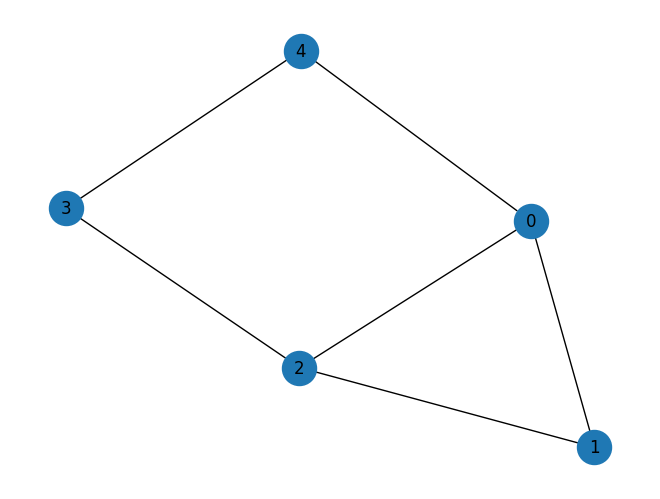

In [48]:
n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

## Step 1: Map Classical Inputs to a Quantum Problem

The first step of the pattern is to map the classical problem (graph) into quantum circuits and operators. To do this, there are three main steps to take:

1. **Utilize a series of mathematical reformulations to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.**

2. **Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution that minimizes the cost function.**

3. **Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.**

### Note:
In the QAOA methodology, you ultimately want to have an operator (Hamiltonian) that represents the cost function of your hybrid algorithm, as well as a parametrized circuit (Ansatz) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.

---

### Graph → Optimization Problem

The first step of the mapping is a notation change. The following expresses the problem in QUBO notation:

$$
\min_{x \in \{0, 1\}^n} x^T Q x,
$$

where $ Q $ is an $ n \times n $ matrix of real numbers, $ n $ corresponds to the number of nodes in your graph, $ x $ is the vector of binary variables introduced above, and $ x^T $ indicates the transpose of the vector $ x $.

#### Example QUBO Formulation

Consider the following optimization problem expressed in QUBO notation:

$$
\text{Maximize } -2x_0x_1 - 2x_0x_2 - 2x_0x_4 - 2x_1x_2 - 2x_2x_3 - 2x_3x_4 + 2x_1 + 3x_2 + 2x_3 + 2x_4
$$

Subject to:
- No constraints
- Binary variables (5): $ x_0, x_1, x_2, x_3, x_4 $

This formulation captures the interactions between nodes in the graph and their contributions to the cost function.

---

## Optimization Problem → Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

$$
H_C = \sum_{ij} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$

### Reformulation Steps from the QAOA Problem to the Hamiltonian

To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $ x_i $ with a new set of variables $ z_i \in \{-1, 1\} $ via

$$
x_i = \frac{1 - z_i}{2}.
$$

Here you can see that if $ x_i = 0 $, then $ z_i $ must be $ 1 $. When the $ x_i $'s are substituted for the $ z_i $'s in the optimization problem ($ x^T Q x $), an equivalent formulation can be obtained.

$$
\begin{aligned}
x^T Q x &= \sum_{ij} Q_{ij} x_i x_j \\
&= \frac{1}{4} \sum_{ij} Q_{ij} (1 - z_i)(1 - z_j) \\
&= \frac{1}{4} \sum_{ij} Q_{ij} z_i z_j - \frac{1}{4} \sum_{ij} (Q_{ij} + Q_{ji}) z_i + \frac{n^2}{4}.
\end{aligned}
$$

Now, if we define $ b_i = -\sum_j (Q_{ij} + Q_{ji}) $, remove the prefactor, and the constant $ n^2 $ term, we arrive at the two equivalent formulations of the same optimization problem:

$$
\min_{x \in \{0, 1\}^n} x^T Q x \iff \min_{z \in \{-1, 1\}^n} z^T Q z + b^T z.
$$

Here, $ b $ depends on $ Q $. Note that to obtain $ z^T Q z + b^T z $, we dropped the factor of $ 1/4 $ and a constant offset of $ n^2 $, which do not play a role in the optimization.

Now, to obtain a quantum formulation of the problem, promote the $ z_i $ variables to a Pauli $ Z $ matrix, such as a $ 2 \times 2 $ matrix of the form

$$
Z_i = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.
$$


When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian:

$$
H_C = \sum_{ij} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$

Also recall that the $ Z $ matrices are embedded in the quantum computer's computational space, that is, a Hilbert space of size $ 2^n \times 2^n $. Therefore, you should understand terms such as $ Z_i Z_j $ as the tensor product $ Z_i \otimes Z_j $ embedded in the $ 2^n \times 2^n $ Hilbert space. For example, in a problem with five decision variables, the term $ Z_1 Z_3 $ is understood to mean $ I \otimes Z_3 \otimes I \otimes Z_1 \otimes I $, where $ I $ is the $ 2 \times 2 $ identity matrix.

This Hamiltonian is called the **cost function Hamiltonian**. It has the property that its ground state corresponds to the solution that minimizes the cost function $ f(x) $. Therefore, to solve your optimization problem, you now need to prepare the ground state of $ H_C $ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $ \min f(x) $.

Now let us consider the Hamiltonian $ H_C $ for the Max-Cut problem. Let each vertex of the graph be associated with a qubit in state $ |0\rangle $ or $ |1\rangle $, where the value denotes the set the vertex is in. The goal of the problem is to maximize the number of edges $ (v_1, v_2) $ for which $ v_1 = |0\rangle $ and $ v_2 = |1\rangle $, or vice versa. If we associate the $ Z $ operator with each qubit, where

$$
Z|0\rangle = |0\rangle \quad \text{and} \quad Z|1\rangle = -|1\rangle,
$$

then an edge $ (v_1, v_2) $ belongs to the cut if the eigenvalue of $ (Z_1 |v_1\rangle) \cdot (Z_2 |v_2\rangle) = -1 $; in other words, the qubits associated with $ v_1 $ and $ v_2 $ are different. Similarly, $ (v_1, v_2) $ does not belong to the cut if the eigenvalue of $ (Z_1 |v_1\rangle) \cdot (Z_2 |v_2\rangle) = 1 $. Note that, we do not care about the exact qubit state associated with each vertex, rather we care only whether they are the same or not across an edge. The Max-Cut problem requires us to find an assignment of the qubits on the vertices such that the eigenvalue of the following Hamiltonian is minimized:

$$
H_C = \sum_{(i,j) \in E} Q_{ij} \cdot Z_i Z_j.
$$

In other words, $ b_i = 0 $ for all $ i $ in the Max-Cut problem. The value of $ Q_{ij} $ denotes the weight of the edge. In this tutorial, we consider an unweighted graph, that is, $ Q_{ij} = 1.0 $ for all $ i, j $.

In [49]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## Hamiltonian → Quantum Circuit

The Hamiltonian $ H_C $ contains the quantum definition of your problem. Now you can create a quantum circuit that will help **sample good solutions** from the quantum computer. The QAOA (Quantum Approximate Optimization Algorithm) is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $ H^{\otimes n} |0\rangle $, and then steer the system into the ground state of the cost operator $ H_C $ that you are interested in. This is done by applying the operators 

$$
\exp\{-i \gamma_k H_C\} \quad \text{and} \quad \exp\{-i \beta_k H_m\}
$$

with angles $ \gamma_1, \dots, \gamma_p $ and $ \beta_1, \dots, \beta_p $.

The quantum circuit that you generate is **parametrized** by $ \gamma_i $ and $ \beta_i $, so you can try out different values of $ \gamma_i $ and $ \beta_i $ and sample from the resulting state.

![citcuit-diagram](/Users/monitsharma/SMU-Quantum/2025-08_UNSW_Quantum_Optimization/Quantum_Hardware/images/circuit-diagram.avif)

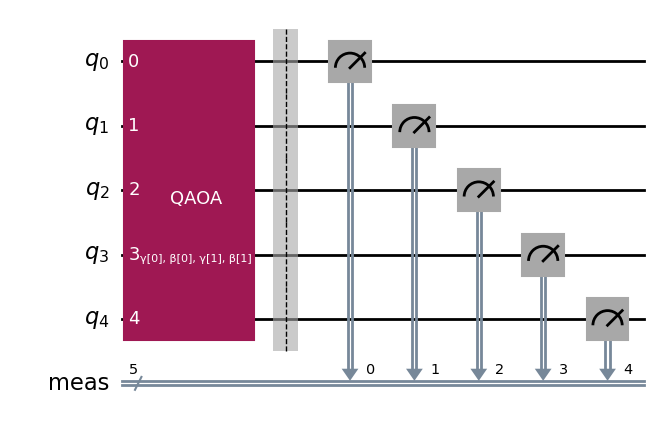

In [50]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
 
circuit.draw("mpl")

You can decompose the circuit and see what's inside the blocks, by setting a  `decompose()` or `reps` 

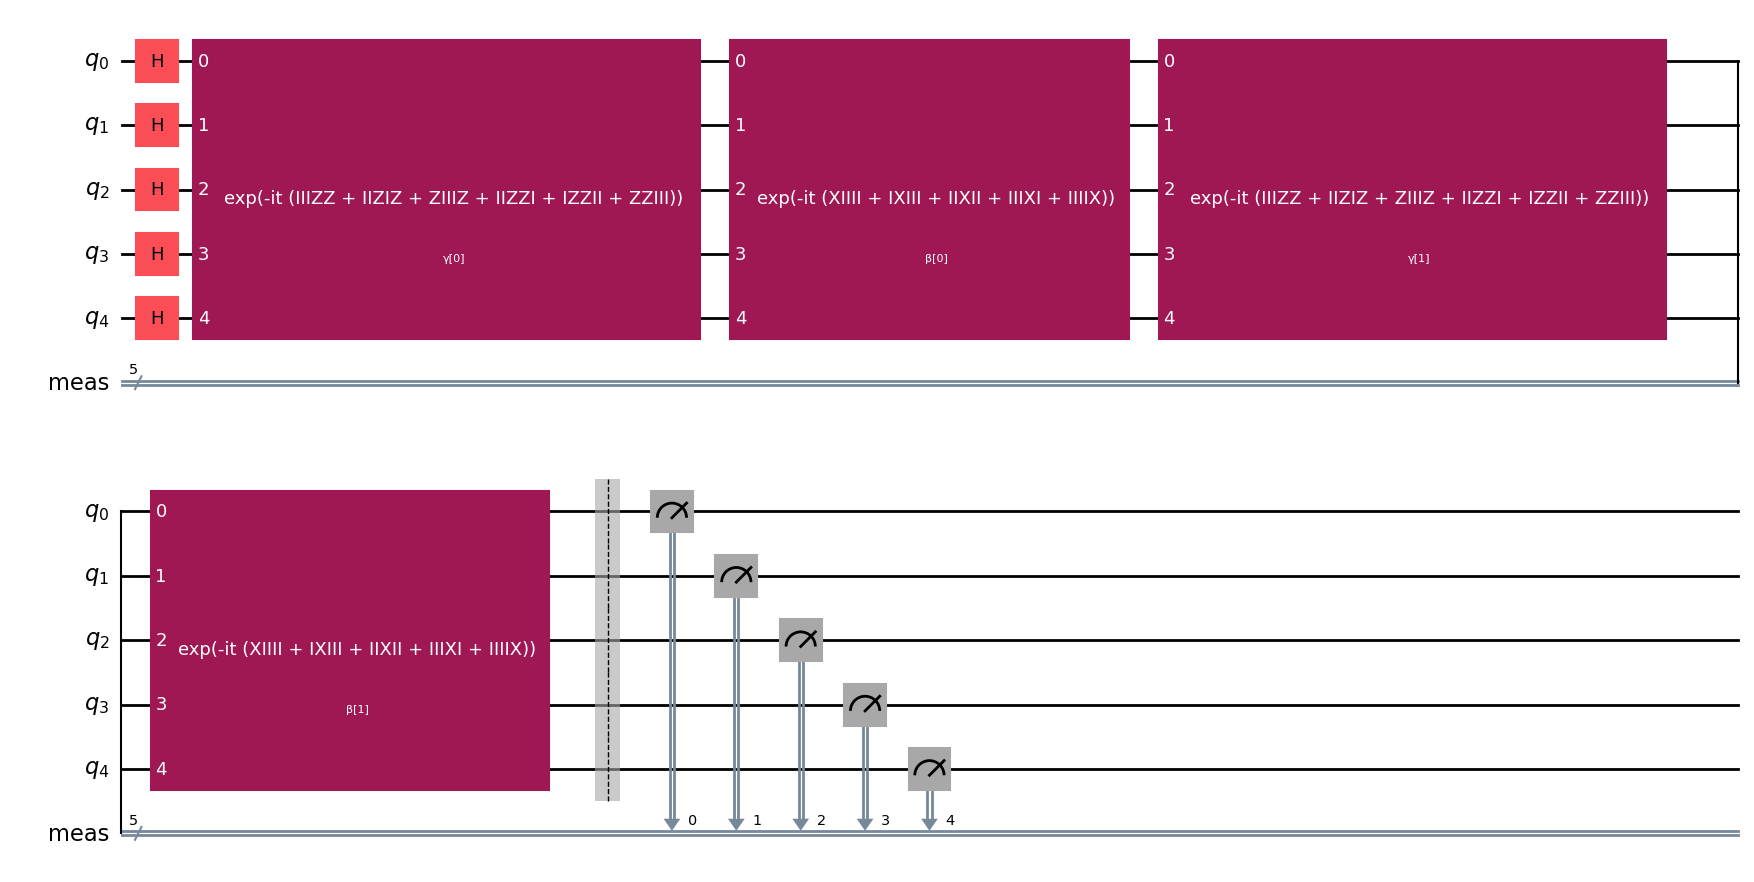

In [51]:
circuit.decompose().draw("mpl")

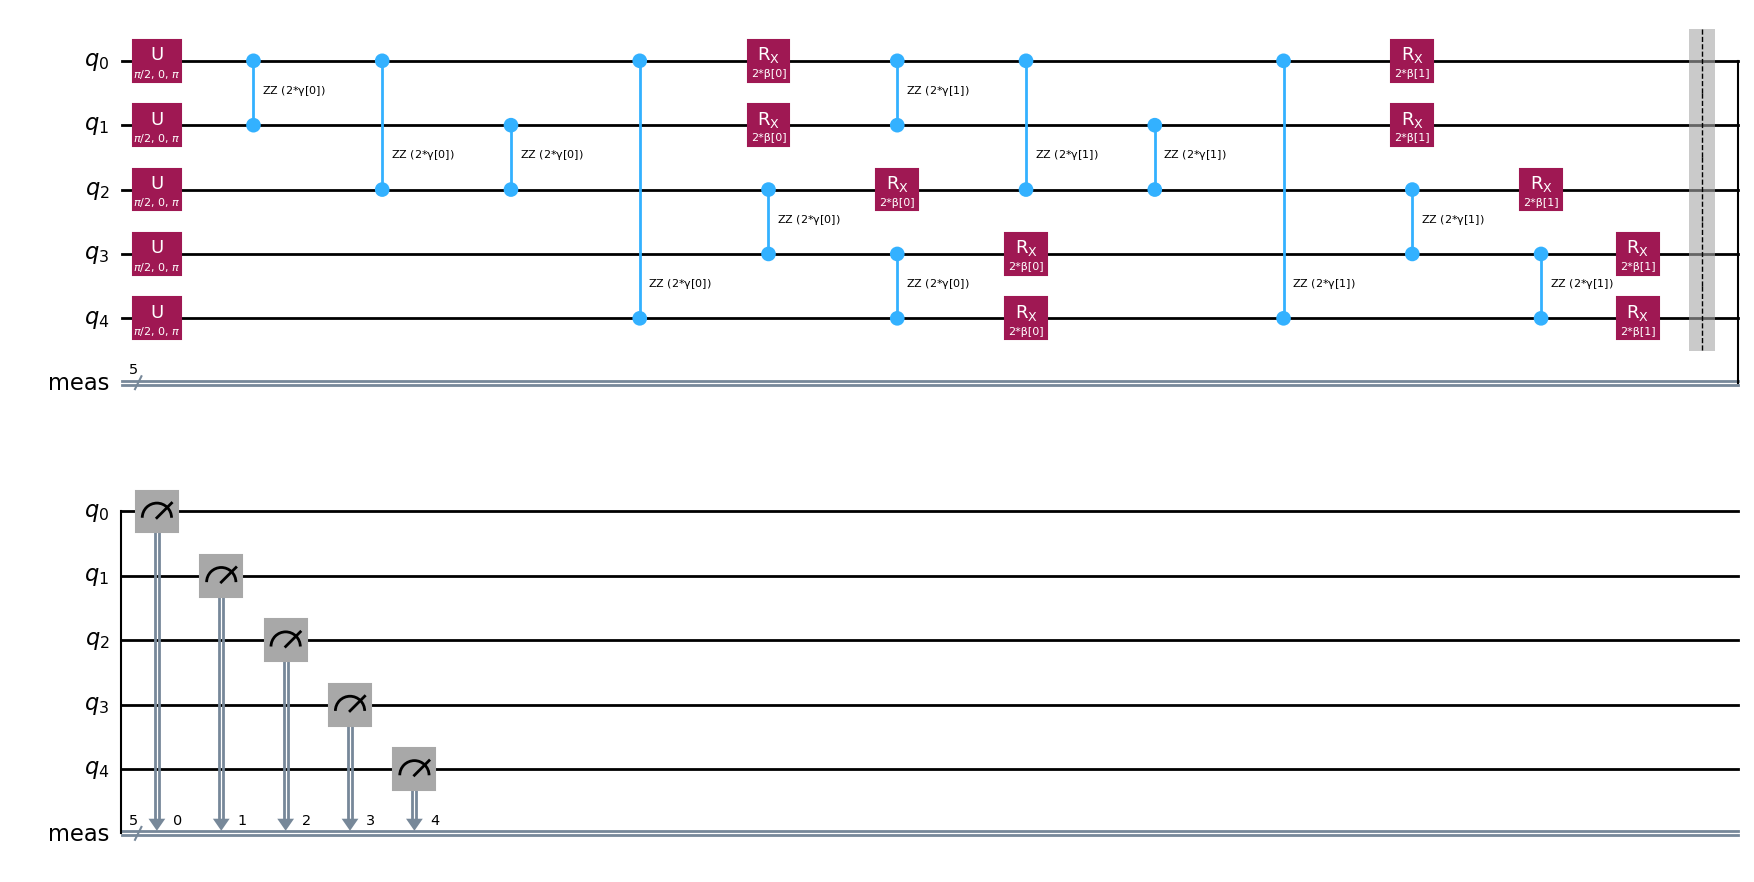

In [52]:
circuit.decompose(reps=2).draw("mpl")

Here are the list of parameters

In [53]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

## Step 2: Optimize Problem for Quantum Hardware Execution

The circuit above contains a series of abstractions useful for thinking about quantum algorithms, but it is not directly executable on quantum hardware. To run on a QPU (Quantum Processing Unit), the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to ensure that your circuit is **optimized** for your specific purpose.

Transpilation may involve several steps, such as:

- **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
- **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
- **Routing** of any qubits in the circuit that interact with physical qubits that are adjacent to one another.
- **Error suppression** by adding single-qubit gates to suppress noise using dynamic decoupling.

More information about transpilation is available in the [documentation](https://quantum.cloud.ibm.com/docs/en/guides/transpile).

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of the devices accessible through the cloud using the **Qiskit IBM Runtime service**.

<IBMBackend('ibm_brisbane')>


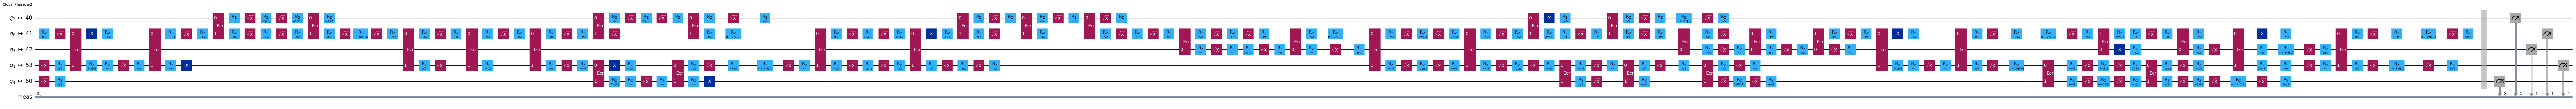

In [54]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [55]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [56]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [69]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator

service = QiskitRuntimeService()  
backend = service.backend(name="ibm_brisbane")   


objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

IBMInputValueError: 'No API client found for given instance: crn:v1:bluemix:public:quantum-computing:us-east:a/f4cf81910e9d4122ab951c68d02cdecc:0d27a1c1-971d-4120-9179-7e62a70f15c6::'

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [ ]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos
    )
 
 
plot_result(graph, most_likely_bitstring)

In [ ]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos
    )
 
 
plot_result(graph, most_likely_bitstring)

In [ ]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

In [ ]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)
 
cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

In [ ]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)
 
cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

In [ ]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)
 
cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_gamma]
 
objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
 
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

In [ ]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw("mpl", fold=False, idle_wires=False)

In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
 
 
pub = (optimized_circuit_100,)
job = sampler.run([pub], shots=int(1e4))
 
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {
    key: val / shots for key, val in counts_int.items()
}

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
_PARITY = np.array(
    [-1 if bin(i).count("1") % 2 else 1 for i in range(256)],
    dtype=np.complex128,
)
 
 
def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(
        state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8
    )
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])
 
 
def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol
 
    return min_sol
 
 
best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()
 
print("Result bitstring:", best_sol_bitstring_100)

In [ ]:
plot_result(graph_100, best_sol_bitstring_100)

In [ ]:
cut_value_100 = evaluate_sample(best_sol_bitstring_100, graph_100)
print("The value of the cut is:", cut_value_100)

In [ ]:
# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)
 
 
def plot_cdf(dist, ax, title):
    _plot_cdf(
        dist,
        ax,
        "C1",
    )
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")
 
    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)
 
 
# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""
 
    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob
 
    return objective_values

In [ ]:
result_dist = samples_to_objective_values(
    final_distribution_100_int, cost_hamiltonian_100
)

In [ ]:
result_dist = samples_to_objective_values(
    final_distribution_100_int, cost_hamiltonian_100
)